In [1]:
!pip install openpyxl

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
!pip install -q -U tensorflow-text

In [3]:
!pip install natasha

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


# Import

In [4]:
import re
import time

import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup  # Для удаления HTML тегов

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.layers import Embedding, Flatten, Input, concatenate, Reshape
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam, Adadelta
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
import tensorflow_hub as hub
import tensorflow_text as text

from natasha import (
    Segmenter,
    MorphVocab,

    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,

    PER,
    NamesExtractor,
    DatesExtractor,
    MoneyExtractor,
    AddrExtractor,

    Doc
)
from matplotlib import pyplot as plt
import joblib
# from google.colab import drive

2023-09-10 05:45:20.112519: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-10 05:45:20.133189: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-10 05:45:20.447156: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Settings
Путь до папки с файлом

In [5]:
# вход на файл
# drive.mount("/content/drive")
DIR = '/home/best/Code/HACKATONS/HacksAi_2023/solution/files/'
df = pd.read_excel(DIR + "CRA_train_1200.xlsx")

# Data

Получам данные

In [6]:
df.head()

,Id,pr_txt,Категория,Уровень рейтинга
0,1,Повышение кредитного рейтинга Акционерного об...,A,A
1,2,«Эксперт РА» подтвердил кредитный рейтинг комп...,BB,BB
2,3,"НКР повысило кредитный рейтинг ООО ""ОТЭКО-Порт...",A,A
3,4,«Эксперт РА» присвоил кредитный рейтинг ПАО «Ф...,AAA,AAA
4,5,29 марта 2023 г. Ведущий рейтинговый аналитик ...,BBB,BBB


In [7]:
df.shape

(1200, 4)

## Data checking

Изучаем данные

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Id                1200 non-null   int64 
 1   pr_txt            1200 non-null   object
 2   Категория         1200 non-null   object
 3   Уровень рейтинга  1200 non-null   object
dtypes: int64(1), object(3)
memory usage: 37.6+ KB


In [9]:
df['Категория'].unique()

array(['A', 'BB', 'AAA', 'BBB', 'AA', 'B', 'C'], dtype=object)

In [10]:
labels_cat = ['A', 'AA', 'AAA', 'B', 'BB', 'BBB', 'C']

In [11]:
df['Уровень рейтинга'].unique()

array(['A', 'BB', 'AAA', 'BBB', 'AA+', 'BB+', 'BB-', 'A-', 'A+', 'B',
       'AA-', 'BBB+', 'BBB-', 'B-', 'AA', 'B+', 'C'], dtype=object)

In [12]:
labels_rat = ['A+', 'A', 'A-', 'AA+', 'AA', 'AA-', 'AAA', 'B+', 'B', 'B-', 'BB+', 'BB', 'BB-', 'BBB+', 'BBB', 'BBB-', 'C']

In [13]:
df['pr_txt'].unique().shape

(1200,)

# Class

Основной класс для работы с NLP

In [14]:
class Nlp:
    def __init__(self):
        # Инициализация объектов, необходимых для обработки текста с использованием Natasha и Spacy.
        self.segmenter = Segmenter()  # Сегментация текста на предложения.
        self.morph_vocab = MorphVocab()  # Создание словаря морфологических данных.
        self.emb = NewsEmbedding()  # Получение векторных представлений слов.
        self.morph_tagger = NewsMorphTagger(self.emb)  # Морфологическая разметка текста.
        self.ner_tagger = NewsNERTagger(self.emb)  # Распознавание именованных сущностей.
        self.loc_extractor = AddrExtractor(self.morph_vocab)  # Извлечение адресов.
        self.names_extractor = NamesExtractor(self.morph_vocab)  # Извлечение имен.
        self.translator = str.maketrans({chr(10): '', chr(9): ''})
        self.stop_words = ['АО «Эксперт РА', 'АКРА', 'Компания', 'Группа', 'Эксперт РА', 'Рейтинговое агентство', 'АО Эксперт  РА', 'Кредитные', 'Оценка внешнее влияние', 'Группа.']


    # Очищаем текст регулярными выражениями
    def clear_text(self, text):
        soup = BeautifulSoup(text)
        text = soup.get_text()
        text = re.sub(r'(http\S+)|(www\S+)|([\w\d]+www\S+)|([\w\d]+http\S+)', '', text)
        text = re.sub(r'[\n\t\«]', ' ', text).strip()  # Перенос, табуляция
        text = re.sub(r'[^\w\d\s\.\,\"]', ' ', text)  # Только слова, цифры, пробелы, точки и запятые
        text = re.sub(r'\s+', ' ', text)  # Удаляем двойные пробелы
        pat = "\s+([{}]+)".format(re.escape("\.\,"))
        text = re.sub("\s{2,}", " ", re.sub(pat, r"\1", text))
        return text


    def natasha_preprocessing(self, text) -> Doc:
        # Предобработка текста с использованием библиотеки Natasha.
        assert type(text) == str  # Проверка на входной текст.
        doc = Doc(text)  # Создание объекта Doc для текста.
        doc.segment(self.segmenter)  # Сегментация текста на предложения.
        doc.tag_morph(self.morph_tagger)  # Морфологическая разметка текста.
        doc.tag_ner(self.ner_tagger)  # Распознавание именованных сущностей.
        return doc


    # В категорийные признаки
    def to_categorical(self, df, labels):
        le = LabelEncoder()
        le.fit(labels)
        label = le.transform(df)
        return to_categorical(label, num_classes=len(labels), dtype='int')


    def get_features(self, text):
        doc = Doc(text)  # Создание объекта Doc для текста.
        doc.segment(self.segmenter)  # Сегментация текста на предложения.
        doc.tag_morph(self.morph_tagger)  # Морфологическая разметка текста.
        doc.tag_ner(self.ner_tagger)
        words = [token.text for token in doc.tokens if token.pos not in ["ADP", "PUNCT", "NUM", "CCONJ", 'PROPN']]
        count = len(words)  # Количество слов в строке
        if count > 0:
            average = sum(len(word) for word in words) / count
            uniq = round(100*len(set(words))/count)  # % уникальных слов в строке
        for span in doc.spans:
          span.normalize(self.morph_vocab)  # Нормализация именованных сущностей.
        ners = [(span.normal, span.type) for span in doc.spans if span.normal not in self.stop_words]
        counted_ners = self.ners_counter(ners)
        features_list = [count, average, uniq, counted_ners["ORG"], counted_ners["LOC"], counted_ners["PER"]]
        return features_list


    def tag_ner(self, text) -> list:
        # Извлечение именованных сущностей из текста.
        doc = self.natasha_preprocessing(text)
        for span in doc.spans:
            span.normalize(self.morph_vocab)  # Нормализация именованных сущностей.
        return [(span.start, span.stop, span.normal, span.type) for span in doc.spans if span.normal not in self.stop_words]


    def ners_counter(self, ners):
        counted_ners = {"ORG": 0, "LOC": 0, "PER": 0}
        for ner in ners:
            counted_ners[ner[1]] += 1
        return counted_ners

In [15]:
nlp = Nlp()

# Cleaning up text
Очищаем текст HTML, гиперссылок, прочих ненужных символов и двойных пробелов

In [16]:
sample_text = ' Присвоенный  https://raexpert.ru/ratings/methods/current ")     рейтинг и прогноз <rating> по нему отражают всю существенную информацию в отношении  объекта рейтинга'

In [17]:
cleared_text = nlp.clear_text(sample_text)
print('ДО:', sample_text)
print()
print('ПОСЛЕ:', cleared_text)

ДО:  Присвоенный  https://raexpert.ru/ratings/methods/current ")     рейтинг и прогноз <rating> по нему отражают всю существенную информацию в отношении  объекта рейтинга

ПОСЛЕ: Присвоенный " рейтинг и прогноз по нему отражают всю существенную информацию в отношении объекта рейтинга


In [18]:
cleared_text_list = []
for i in range(df.shape[0]):
    text = nlp.clear_text(df['pr_txt'].iloc[i])
    cleared_text_list.append(text)

print(len(cleared_text_list))

1200


# To categorical

Переводим каегории и рейтинги в OHE

In [19]:
cat_categorical = nlp.to_categorical(df['Категория'], labels_cat)
rating_categorical = nlp.to_categorical(df['Уровень рейтинга'], labels_rat)
print(cat_categorical.shape, rating_categorical.shape)

(1200, 7) (1200, 17)


# To dataFrame

In [20]:
df_text = pd.DataFrame(cleared_text_list, columns=['text'])
df_cat = pd.DataFrame(cat_categorical)
df_rat = pd.DataFrame(rating_categorical)
print(df_text.shape, df_cat.shape, df_rat.shape)

(1200, 1) (1200, 7) (1200, 17)


## Feature Extraction
Извлекаем дополнительные признаки, такие как:
- NER - имена, названия
- NER - даты
- NER - деньги  # Выкидывает ошибку на обработке некоторых текстов
- NER - локации, адреса
- длинна текста
- средняя длинна слова
- уникальность текста

ВНИМАНИЕ!
Извлечение именованных сущностей - долгий процесс!!!

In [21]:
x_features = np.array(list(df_text['text'].map(nlp.get_features)))
x_features.shape

(1200, 6)

In [22]:
x_features

array([[7.94000000e+02, 8.11335013e+00, 6.10000000e+01, 2.80000000e+01,
        8.00000000e+00, 0.00000000e+00],
       [7.48000000e+02, 8.32085561e+00, 7.00000000e+01, 3.30000000e+01,
        3.00000000e+00, 0.00000000e+00],
       [1.10800000e+03, 8.13357401e+00, 6.40000000e+01, 4.50000000e+01,
        2.50000000e+01, 2.00000000e+00],
       ...,
       [8.03000000e+02, 8.00747198e+00, 6.00000000e+01, 3.60000000e+01,
        4.00000000e+00, 1.00000000e+00],
       [9.39000000e+02, 8.02449414e+00, 6.50000000e+01, 3.60000000e+01,
        2.40000000e+01, 0.00000000e+00],
       [1.11200000e+03, 7.98291367e+00, 6.50000000e+01, 4.70000000e+01,
        4.00000000e+00, 0.00000000e+00]])

In [23]:
x_features_np = np.array(x_features)

In [24]:
np.save(DIR + 'x_features_3.npy', x_features_np)

In [25]:
df_features = pd.DataFrame(x_features, columns=['name', 'date', 'location', 'count', 'average', 'uniq'])
df_features.to_csv(DIR + 'df_features_2.csv')
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      1200 non-null   float64
 1   date      1200 non-null   float64
 2   location  1200 non-null   float64
 3   count     1200 non-null   float64
 4   average   1200 non-null   float64
 5   uniq      1200 non-null   float64
dtypes: float64(6)
memory usage: 56.4 KB


In [26]:
# x_features_np = numpy.load(DIR + 'x_features_3.npy')

In [27]:
# df_features = pd.read_csv(DIR + 'df_features_3.csv')

# Data analysis

### Histogramm

Text(0, 0.5, 'Количество текстов')

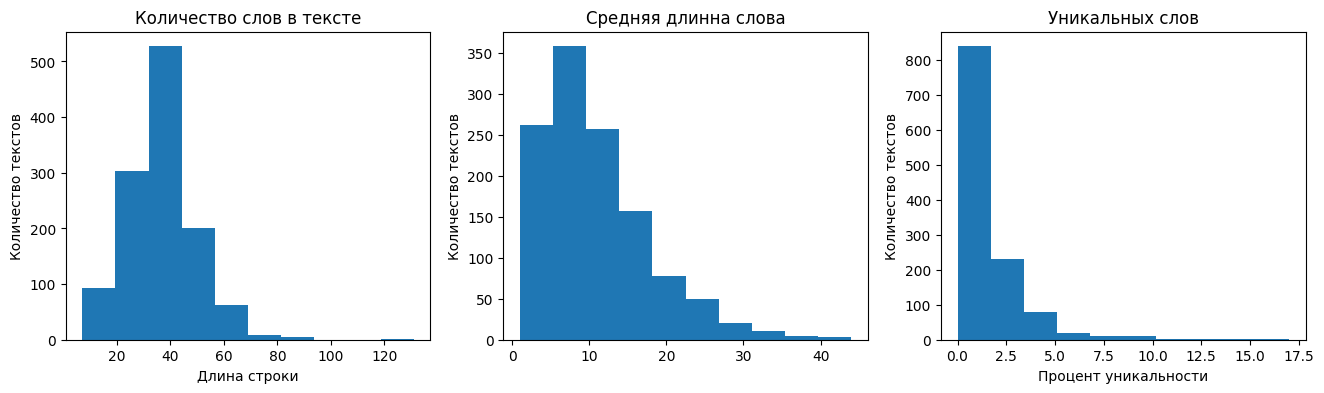

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))

n_bins = 10
axs[0].hist(x_features_np[:,3], bins=n_bins)
axs[0].set_title('Количество слов в тексте')
axs[0].set_xlabel("Длина строки")
axs[0].set_ylabel("Количество текстов")
axs[1].hist(x_features_np[:,4], bins=n_bins)
axs[1].set_title('Средняя длинна слова')
axs[1].set_ylabel("Количество текстов")
axs[2].hist(x_features_np[:,5], bins=n_bins)
axs[2].set_title('Уникальных слов')
axs[2].set_xlabel("Процент уникальности")
axs[2].set_ylabel("Количество текстов")

### Scatter

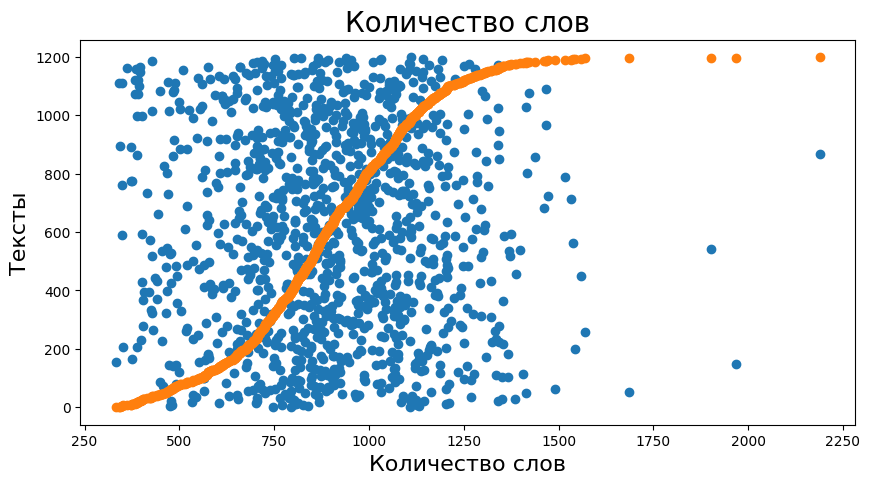

In [29]:
x_np = np.arange(0, df_text['text'].shape[0])

plt.figure(figsize=(10, 5))
plt.title(label = 'Количество слов', fontsize=20)
plt.xlabel('Количество слов', fontsize=16)
plt.ylabel('Тексты', fontsize=16)
plt.scatter(x_features_np[:,0], x_np)
plt.scatter(np.sort(x_features_np[:,0]), x_np)
plt.show()

### Fractions

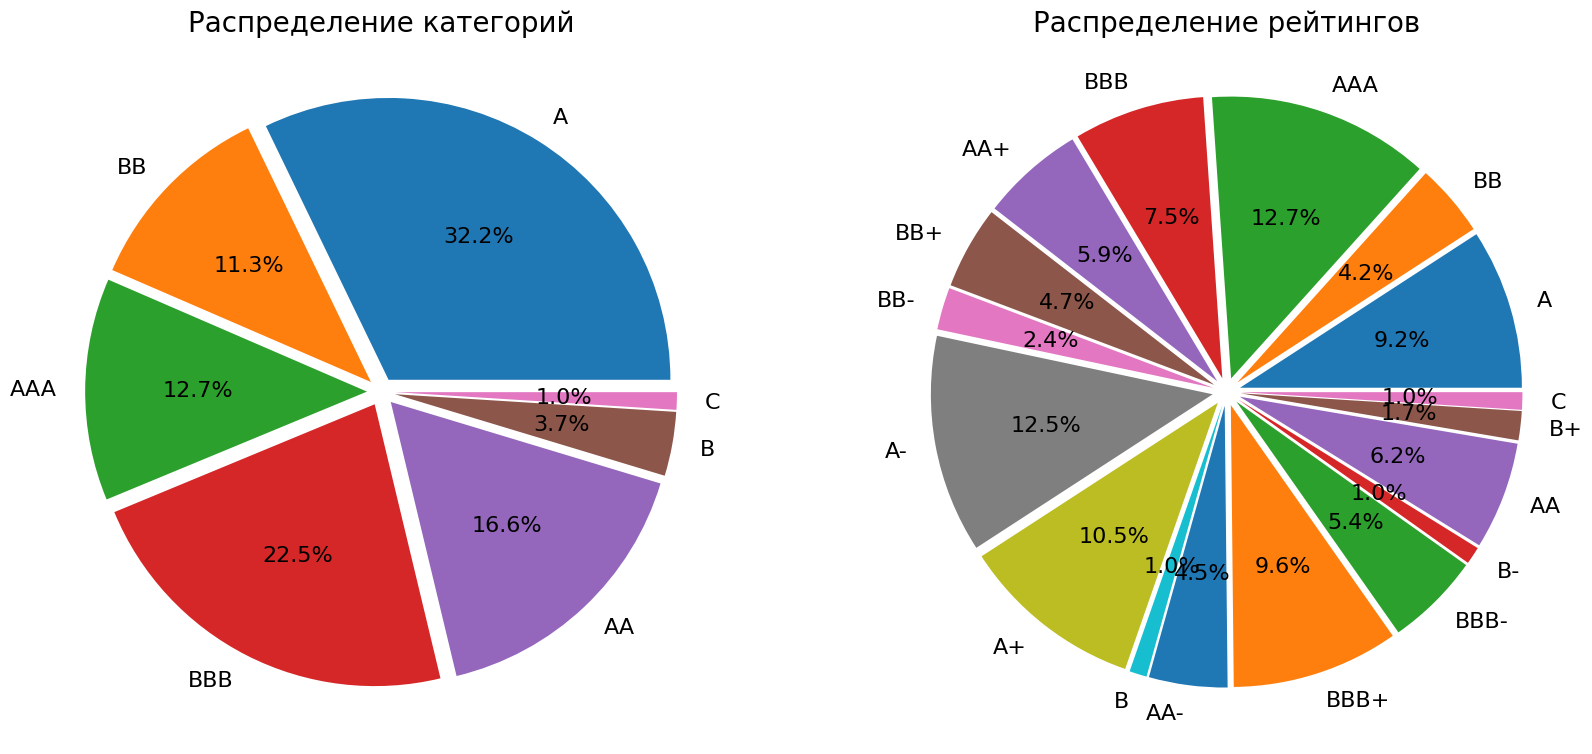

In [30]:
# === Категории ===
cat_list = ['A', 'BB', 'AAA', 'BBB', 'AA', 'B', 'C']
cat_frac_list = []
for cat in cat_list:
  frac = round(100*df[df['Категория'] == cat].shape[0]/df.shape[0], 2)
  cat_frac_list.append(frac)

# === Рейтинги ===
rat_list = ['A', 'BB', 'AAA', 'BBB', 'AA+', 'BB+', 'BB-', 'A-', 'A+', 'B', 'AA-', 'BBB+', 'BBB-', 'B-', 'AA', 'B+', 'C']
rat_frac_list = []
for rat in rat_list:
  frac = round(100*df[df['Уровень рейтинга'] == rat].shape[0]/df.shape[0], 2)
  rat_frac_list.append(frac)

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].pie(cat_frac_list, labels=cat_list, autopct='%1.1f%%', explode=(0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05), textprops = {"fontsize":16})
axs[0].set_title(label='Распределение категорий', fontsize=20)
axs[1].pie(rat_frac_list, labels=rat_list, autopct='%1.1f%%', explode=(0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05), textprops = {"fontsize":16})
axs[1].set_title(label='Распределение рейтингов', fontsize=20)
plt.show()


# train_test_split

In [31]:
x_cat_train, x_cat_val, y_cat_train, y_cat_val = train_test_split(df_text, df_cat, train_size=0.8, random_state=12)
x_rat_train, x_rat_val, y_rat_train, y_rat_val = train_test_split(df_text, df_rat, train_size=0.8, random_state=12)
x_feat_train, x_feat_val = train_test_split(x_features, train_size=0.8, random_state=12)

In [32]:
print(x_cat_train.shape, x_cat_val.shape)
print(x_rat_train.shape, x_rat_val.shape)
print(x_feat_train.shape, x_feat_val.shape)

(960, 1) (240, 1)
(960, 1) (240, 1)
(960, 6) (240, 6)


In [33]:
print(y_cat_train.shape, y_cat_val.shape)
print(y_rat_train.shape, y_rat_val.shape)

(960, 7) (240, 7)
(960, 17) (240, 17)


# Loading the BERT Model
We will load two models, one for pre-processing and one for coding. Model links are below.

In [34]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/4", trainable=True)

2023-09-10 05:47:04.921216: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-10 05:47:04.934070: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-10 05:47:04.934157: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

# Initializing BERT Layers
In the code below, create an input layer using the tf.keras.layers.Input method. Will use **preprocessed_text** as input for this layer.

The **bert_encoder** function then converts the preprocessed text into embadding vectors. This will be the output of this layer. The **outputs** will then be passed to the layers of the neural network.

In [35]:
text_input = Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# === model_cat ===
Модель для работы с категориями
Представляет собой Fine Tuning BERT (SOTA) - предварительно обученная модель, которая дообучается на наших данных.
Дополнительно для улучшения скора - создаём дополнительный вход и подаём туда фичи.
Итого, модель с 2 входами:
- текст
- 6 признаков


## Model with multiple inputs
Модель с двумя входами

In [36]:
text_input = Input(shape=(), dtype=tf.string, name='text_input')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

features_input = Input(shape=(6), name='features_input')
x_1 = outputs['pooled_output']
x_2 = Dense(6, activation='relu')(features_input)
x = concatenate([x_1, x_2])
x = Dropout(0.25)(x)
x_output = Dense(7, activation='softmax')(x)

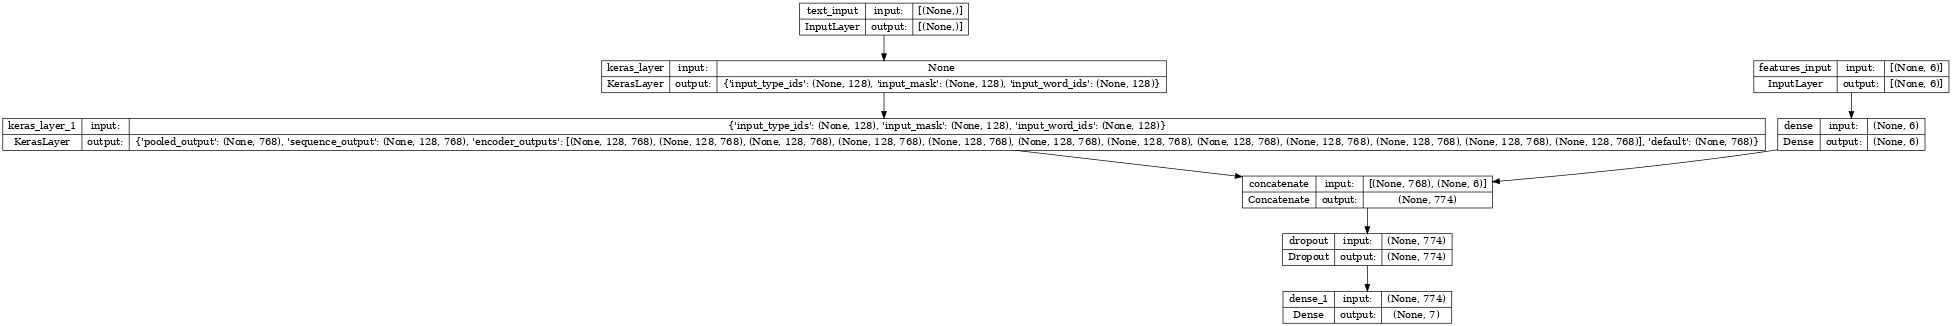

In [37]:
model_cat = Model(inputs=[text_input, features_input], outputs = [x_output])
plot_model(model_cat, show_shapes=True, expand_nested=True, show_layer_names=True, dpi=50)

In [38]:
print(model_cat.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_type_ids': (None,    0         ['text_input[0][0]']          
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_word_ids': (None,                                           
                              128)}                                                               
                                                                                              

## Model complite
Особенность - очень маленький шаг обучения. Для ускорения обучения до 5 - 7 эпох, можно поднять learning_rate до 0.00005, но не более. Далее - существенное снижение точности.

In [39]:
model_cat.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=(0.00001)), metrics=['accuracy'])

checkpointer = ModelCheckpoint(
  filepath = DIR + 'model_cat_3_w.h5',
  monitor = 'val_accuracy',
  mode = 'max',
  verbose = 1,
  save_best_only = True
)

In [40]:
history = model_cat.fit(
  [x_cat_train, x_feat_train],
  y_cat_train,
  epochs = 120,
  batch_size = 16,
  validation_data = ([x_cat_val, x_feat_val], y_cat_val),
  callbacks = [checkpointer],
  verbose = 1
)

Epoch 1/120


2023-09-10 05:47:15.819684: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-09-10 05:47:15.843985: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fa5a40fc480 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-10 05:47:15.843995: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2023-09-10 05:47:15.846757: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-10 05:47:15.929541: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-09-10 05:47:15.983131: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

60/60 [==============================] - ETA: 0s - loss: 25.8457 - accuracy: 0.0927
Epoch 1: val_accuracy improved from -inf to 0.30833, saving model to /home/best/Code/HACKATONS/HacksAi_2023/solution/files/model_cat_3_w.h5


/home/best/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


60/60 [==============================] - 27s 208ms/step - loss: 25.8457 - accuracy: 0.0927 - val_loss: 14.0824 - val_accuracy: 0.3083
Epoch 2/120
60/60 [==============================] - ETA: 0s - loss: 21.7265 - accuracy: 0.1990
Epoch 2: val_accuracy did not improve from 0.30833
60/60 [==============================] - 9s 153ms/step - loss: 21.7265 - accuracy: 0.1990 - val_loss: 13.0754 - val_accuracy: 0.3083
Epoch 3/120
60/60 [==============================] - ETA: 0s - loss: 19.3630 - accuracy: 0.1937
Epoch 3: val_accuracy did not improve from 0.30833
60/60 [==============================] - 8s 138ms/step - loss: 19.3630 - accuracy: 0.1937 - val_loss: 12.3216 - val_accuracy: 0.3083
Epoch 4/120
60/60 [==============================] - ETA: 0s - loss: 17.9254 - accuracy: 0.2021
Epoch 4: val_accuracy did not improve from 0.30833
60/60 [==============================] - 8s 138ms/step - loss: 17.9254 - accuracy: 0.2021 - val_loss: 11.5307 - val_accuracy: 0.3083
Epoch 5/120
60/60 [=======

Epoch 27/120
60/60 [==============================] - ETA: 0s - loss: 4.1533 - accuracy: 0.6687
Epoch 27: val_accuracy did not improve from 0.68750
60/60 [==============================] - 7s 117ms/step - loss: 4.1533 - accuracy: 0.6687 - val_loss: 4.2901 - val_accuracy: 0.6583
Epoch 28/120
60/60 [==============================] - ETA: 0s - loss: 3.8005 - accuracy: 0.6448
Epoch 28: val_accuracy did not improve from 0.68750
60/60 [==============================] - 7s 117ms/step - loss: 3.8005 - accuracy: 0.6448 - val_loss: 3.9945 - val_accuracy: 0.6750
Epoch 29/120
60/60 [==============================] - ETA: 0s - loss: 3.4999 - accuracy: 0.6969
Epoch 29: val_accuracy did not improve from 0.68750
60/60 [==============================] - 7s 120ms/step - loss: 3.4999 - accuracy: 0.6969 - val_loss: 4.4853 - val_accuracy: 0.6667
Epoch 30/120
60/60 [==============================] - ETA: 0s - loss: 3.3027 - accuracy: 0.7104
Epoch 30: val_accuracy improved from 0.68750 to 0.70833, saving mod

60/60 [==============================] - 7s 118ms/step - loss: 1.2748 - accuracy: 0.8979 - val_loss: 3.9539 - val_accuracy: 0.7125
Epoch 56/120
60/60 [==============================] - ETA: 0s - loss: 1.0118 - accuracy: 0.8969
Epoch 56: val_accuracy did not improve from 0.73750
60/60 [==============================] - 7s 118ms/step - loss: 1.0118 - accuracy: 0.8969 - val_loss: 4.1300 - val_accuracy: 0.7208
Epoch 57/120
60/60 [==============================] - ETA: 0s - loss: 1.0401 - accuracy: 0.9094
Epoch 57: val_accuracy did not improve from 0.73750
60/60 [==============================] - 7s 117ms/step - loss: 1.0401 - accuracy: 0.9094 - val_loss: 5.8756 - val_accuracy: 0.7000
Epoch 58/120
60/60 [==============================] - ETA: 0s - loss: 0.8668 - accuracy: 0.9135
Epoch 58: val_accuracy did not improve from 0.73750
60/60 [==============================] - 7s 117ms/step - loss: 0.8668 - accuracy: 0.9135 - val_loss: 4.3449 - val_accuracy: 0.7292
Epoch 59/120
60/60 [============

Epoch 84/120
60/60 [==============================] - ETA: 0s - loss: 0.5031 - accuracy: 0.9521
Epoch 84: val_accuracy did not improve from 0.76667
60/60 [==============================] - 7s 118ms/step - loss: 0.5031 - accuracy: 0.9521 - val_loss: 4.5341 - val_accuracy: 0.7417
Epoch 85/120
60/60 [==============================] - ETA: 0s - loss: 0.2798 - accuracy: 0.9698
Epoch 85: val_accuracy did not improve from 0.76667
60/60 [==============================] - 7s 119ms/step - loss: 0.2798 - accuracy: 0.9698 - val_loss: 4.4679 - val_accuracy: 0.7417
Epoch 86/120
60/60 [==============================] - ETA: 0s - loss: 0.3897 - accuracy: 0.9552
Epoch 86: val_accuracy did not improve from 0.76667
60/60 [==============================] - 7s 120ms/step - loss: 0.3897 - accuracy: 0.9552 - val_loss: 4.5484 - val_accuracy: 0.7625
Epoch 87/120
60/60 [==============================] - ETA: 0s - loss: 0.4048 - accuracy: 0.9563
Epoch 87: val_accuracy did not improve from 0.76667
60/60 [========

60/60 [==============================] - ETA: 0s - loss: 0.2869 - accuracy: 0.9750
Epoch 113: val_accuracy did not improve from 0.76667
60/60 [==============================] - 7s 118ms/step - loss: 0.2869 - accuracy: 0.9750 - val_loss: 3.8989 - val_accuracy: 0.7542
Epoch 114/120
60/60 [==============================] - ETA: 0s - loss: 0.1244 - accuracy: 0.9844
Epoch 114: val_accuracy improved from 0.76667 to 0.78333, saving model to /home/best/Code/HACKATONS/HacksAi_2023/solution/files/model_cat_3_w.h5
60/60 [==============================] - 9s 151ms/step - loss: 0.1244 - accuracy: 0.9844 - val_loss: 3.9830 - val_accuracy: 0.7833
Epoch 115/120
60/60 [==============================] - ETA: 0s - loss: 0.0836 - accuracy: 0.9917
Epoch 115: val_accuracy did not improve from 0.78333
60/60 [==============================] - 7s 119ms/step - loss: 0.0836 - accuracy: 0.9917 - val_loss: 4.2120 - val_accuracy: 0.7500
Epoch 116/120
60/60 [==============================] - ETA: 0s - loss: 0.1655 -

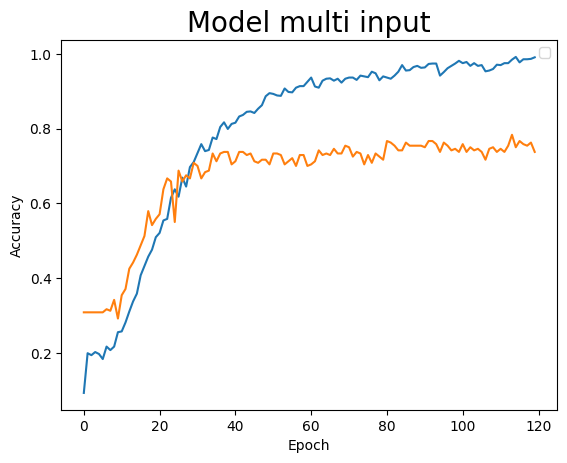

In [41]:
# Оображаем график точности обучения
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title(label='Model multi input', fontsize=20)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Evaluate the model
Загружаем лучшие веса модели и оцениваем модель

In [42]:
model_cat.load_weights(DIR + 'model_cat_3_w.h5')

In [43]:
loss, accuracy = model_cat.evaluate([x_cat_train, x_feat_train], y_cat_train)
print(f'Train, accuracy: {accuracy}, loss: {loss}')
print()

val_loss, val_accuracy = model_cat.evaluate([x_cat_val, x_feat_val], y_cat_val)
print(f'Val, accuracy: {val_accuracy}, loss: {val_loss}')

30/30 [==============================] - 5s 149ms/step - loss: 0.0081 - accuracy: 0.9969
Train, accuracy: 0.996874988079071, loss: 0.008113604038953781

8/8 [==============================] - 1s 138ms/step - loss: 3.9830 - accuracy: 0.7833
Val, accuracy: 0.7833333611488342, loss: 3.9829788208007812


In [44]:
y_pred_v = model_cat.predict([x_cat_val, x_feat_val])
y_pred_am = np.argmax(y_pred_v, axis=1)
y_pred = to_categorical(y_pred_am,  num_classes=7, dtype='int')
print(y_cat_val.shape, y_pred.shape)

8/8 [==============================] - 1s 124ms/step
(240, 7) (240, 7)


In [45]:
y_pred

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

In [46]:
y_cat_val

,0,1,2,3,4,5,6
1074,1,0,0,0,0,0,0
289,0,0,0,0,1,0,0
883,0,0,0,1,0,0,0
1045,1,0,0,0,0,0,0
1057,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...
915,0,0,0,0,0,1,0
217,1,0,0,0,0,0,0
168,0,0,0,0,0,1,0
1104,1,0,0,0,0,0,0


In [47]:
f1 = sklearn.metrics.f1_score(y_cat_val, y_pred, average='macro')
print(f1)

0.706763161878835


# Save model

In [48]:
model_cat.save(DIR + 'model_cat_3.keras')

# === model_rating ===
Модель для работы с рейтингом
Представляет собой Fine Tuning BERT (SOTA) - предварительно обученная модель, которая дообучается на наших данных.
Дополнительно для улучшения скора - создаём дополнительный вход и подаём туда фичи.
Итого, модель с 2 входами:
- текст
- 6 признаков

## Model with multiple inputs
Модель с двумя входами

In [49]:
text_input = Input(shape=(), dtype=tf.string, name='text_input')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

features_input = Input(shape=(6), name='features_input')
x_1 = outputs['pooled_output']
x_2 = Dense(6, activation='relu')(features_input)
x = concatenate([x_1, x_2])
x = Dropout(0.25)(x)
x_output = Dense(17, activation='softmax')(x)

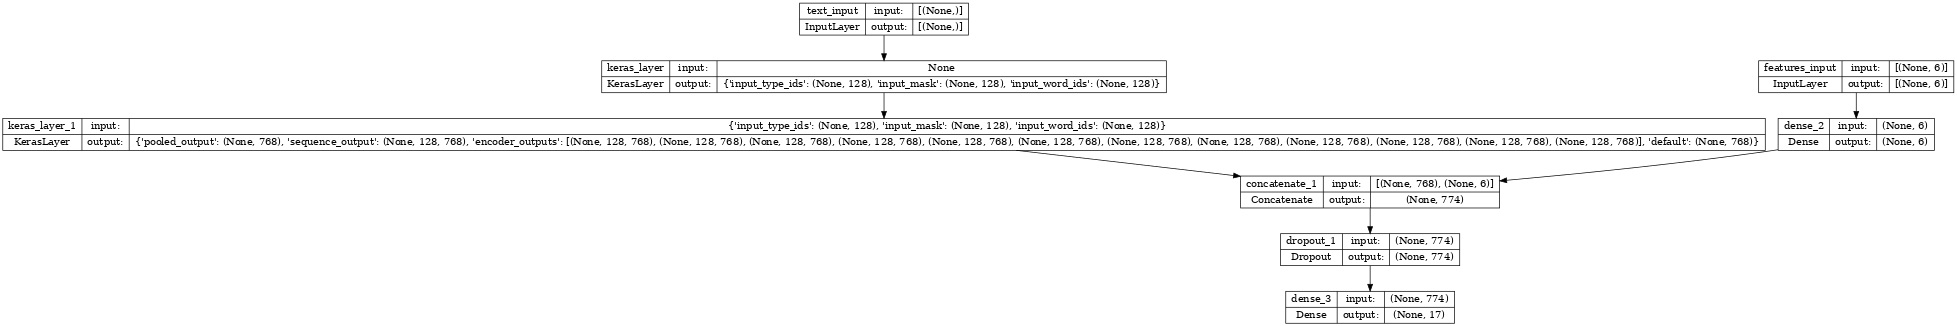

In [50]:
model_rat = Model(inputs=[text_input, features_input], outputs = [x_output])
plot_model(model_rat, show_shapes=True, expand_nested=True, show_layer_names=True, dpi=50)

In [51]:
print(model_rat.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_type_ids': (None,    0         ['text_input[0][0]']          
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_word_ids': (None,                                           
                              128)}                                                               
                                                                                            

## Model complite
Особенность - очень маленький шаг обучения. Для ускорения обучения до 5 - 7 эпох, можно поднять learning_rate до 0.00005, но не более. Далее - существенное снижение точности.

In [52]:
model_rat.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=(0.00001)), metrics=['accuracy'])

checkpointer = ModelCheckpoint(
  filepath = DIR + 'model_rat_3_w.h5',
  monitor = 'val_accuracy',
  mode = 'max',
  verbose = 1,
  save_best_only = True
)

In [53]:
history = model_rat.fit(
  [x_rat_train, x_feat_train],
  y_rat_train,
  epochs = 150,
  batch_size = 16,
  validation_data = ([x_rat_val, x_feat_val], y_rat_val),
  callbacks = [checkpointer],
  verbose = 1
)

Epoch 1/150
60/60 [==============================] - ETA: 0s - loss: 13.4475 - accuracy: 0.1271
Epoch 1: val_accuracy improved from -inf to 0.13750, saving model to /home/best/Code/HACKATONS/HacksAi_2023/solution/files/model_rat_3_w.h5


/home/best/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


60/60 [==============================] - 23s 186ms/step - loss: 13.4475 - accuracy: 0.1271 - val_loss: 10.8799 - val_accuracy: 0.1375
Epoch 2/150
60/60 [==============================] - ETA: 0s - loss: 11.3975 - accuracy: 0.2073
Epoch 2: val_accuracy improved from 0.13750 to 0.22500, saving model to /home/best/Code/HACKATONS/HacksAi_2023/solution/files/model_rat_3_w.h5
60/60 [==============================] - 10s 175ms/step - loss: 11.3975 - accuracy: 0.2073 - val_loss: 9.1514 - val_accuracy: 0.2250
Epoch 3/150
60/60 [==============================] - ETA: 0s - loss: 9.9348 - accuracy: 0.2865
Epoch 3: val_accuracy improved from 0.22500 to 0.28333, saving model to /home/best/Code/HACKATONS/HacksAi_2023/solution/files/model_rat_3_w.h5
60/60 [==============================] - 10s 165ms/step - loss: 9.9348 - accuracy: 0.2865 - val_loss: 8.0687 - val_accuracy: 0.2833
Epoch 4/150
60/60 [==============================] - ETA: 0s - loss: 8.7839 - accuracy: 0.3313
Epoch 4: val_accuracy did not

Epoch 28/150
60/60 [==============================] - ETA: 0s - loss: 1.2345 - accuracy: 0.8510
Epoch 28: val_accuracy did not improve from 0.58333
60/60 [==============================] - 7s 120ms/step - loss: 1.2345 - accuracy: 0.8510 - val_loss: 5.3592 - val_accuracy: 0.5750
Epoch 29/150
60/60 [==============================] - ETA: 0s - loss: 1.0649 - accuracy: 0.8698
Epoch 29: val_accuracy improved from 0.58333 to 0.58750, saving model to /home/best/Code/HACKATONS/HacksAi_2023/solution/files/model_rat_3_w.h5
60/60 [==============================] - 9s 151ms/step - loss: 1.0649 - accuracy: 0.8698 - val_loss: 5.4002 - val_accuracy: 0.5875
Epoch 30/150
60/60 [==============================] - ETA: 0s - loss: 1.1247 - accuracy: 0.8708
Epoch 30: val_accuracy did not improve from 0.58750
60/60 [==============================] - 7s 119ms/step - loss: 1.1247 - accuracy: 0.8708 - val_loss: 5.4408 - val_accuracy: 0.5875
Epoch 31/150
60/60 [==============================] - ETA: 0s - loss: 1

Epoch 57/150
60/60 [==============================] - ETA: 0s - loss: 0.3793 - accuracy: 0.9490
Epoch 57: val_accuracy did not improve from 0.61250
60/60 [==============================] - 7s 120ms/step - loss: 0.3793 - accuracy: 0.9490 - val_loss: 6.4847 - val_accuracy: 0.5458
Epoch 58/150
60/60 [==============================] - ETA: 0s - loss: 0.3572 - accuracy: 0.9542
Epoch 58: val_accuracy did not improve from 0.61250
60/60 [==============================] - 7s 117ms/step - loss: 0.3572 - accuracy: 0.9542 - val_loss: 5.7234 - val_accuracy: 0.6000
Epoch 59/150
60/60 [==============================] - ETA: 0s - loss: 0.3275 - accuracy: 0.9552
Epoch 59: val_accuracy did not improve from 0.61250
60/60 [==============================] - 7s 119ms/step - loss: 0.3275 - accuracy: 0.9552 - val_loss: 6.4150 - val_accuracy: 0.5417
Epoch 60/150
60/60 [==============================] - ETA: 0s - loss: 0.3818 - accuracy: 0.9521
Epoch 60: val_accuracy did not improve from 0.61250
60/60 [========

60/60 [==============================] - 7s 119ms/step - loss: 0.1149 - accuracy: 0.9875 - val_loss: 6.2951 - val_accuracy: 0.5625
Epoch 87/150
60/60 [==============================] - ETA: 0s - loss: 0.0850 - accuracy: 0.9844
Epoch 87: val_accuracy did not improve from 0.61250
60/60 [==============================] - 7s 118ms/step - loss: 0.0850 - accuracy: 0.9844 - val_loss: 6.5508 - val_accuracy: 0.5917
Epoch 88/150
60/60 [==============================] - ETA: 0s - loss: 0.0926 - accuracy: 0.9844
Epoch 88: val_accuracy did not improve from 0.61250
60/60 [==============================] - 7s 119ms/step - loss: 0.0926 - accuracy: 0.9844 - val_loss: 6.3880 - val_accuracy: 0.5792
Epoch 89/150
60/60 [==============================] - ETA: 0s - loss: 0.1742 - accuracy: 0.9760
Epoch 89: val_accuracy did not improve from 0.61250
60/60 [==============================] - 7s 120ms/step - loss: 0.1742 - accuracy: 0.9760 - val_loss: 6.4166 - val_accuracy: 0.5750
Epoch 90/150
60/60 [============

Epoch 116/150
60/60 [==============================] - ETA: 0s - loss: 0.0755 - accuracy: 0.9854
Epoch 116: val_accuracy did not improve from 0.61250
60/60 [==============================] - 7s 118ms/step - loss: 0.0755 - accuracy: 0.9854 - val_loss: 6.9440 - val_accuracy: 0.5667
Epoch 117/150
60/60 [==============================] - ETA: 0s - loss: 0.1512 - accuracy: 0.9844
Epoch 117: val_accuracy did not improve from 0.61250
60/60 [==============================] - 7s 118ms/step - loss: 0.1512 - accuracy: 0.9844 - val_loss: 6.4933 - val_accuracy: 0.5833
Epoch 118/150
60/60 [==============================] - ETA: 0s - loss: 0.0986 - accuracy: 0.9823
Epoch 118: val_accuracy did not improve from 0.61250
60/60 [==============================] - 7s 119ms/step - loss: 0.0986 - accuracy: 0.9823 - val_loss: 6.3302 - val_accuracy: 0.5667
Epoch 119/150
60/60 [==============================] - ETA: 0s - loss: 0.1742 - accuracy: 0.9729
Epoch 119: val_accuracy did not improve from 0.61250
60/60 [

60/60 [==============================] - ETA: 0s - loss: 0.1941 - accuracy: 0.9698
Epoch 145: val_accuracy did not improve from 0.61250
60/60 [==============================] - 7s 119ms/step - loss: 0.1941 - accuracy: 0.9698 - val_loss: 6.4679 - val_accuracy: 0.5792
Epoch 146/150
60/60 [==============================] - ETA: 0s - loss: 0.1122 - accuracy: 0.9823
Epoch 146: val_accuracy did not improve from 0.61250
60/60 [==============================] - 7s 119ms/step - loss: 0.1122 - accuracy: 0.9823 - val_loss: 6.5325 - val_accuracy: 0.5667
Epoch 147/150
60/60 [==============================] - ETA: 0s - loss: 0.1117 - accuracy: 0.9844
Epoch 147: val_accuracy did not improve from 0.61250
60/60 [==============================] - 7s 119ms/step - loss: 0.1117 - accuracy: 0.9844 - val_loss: 6.7117 - val_accuracy: 0.5542
Epoch 148/150
60/60 [==============================] - ETA: 0s - loss: 0.1277 - accuracy: 0.9854
Epoch 148: val_accuracy did not improve from 0.61250
60/60 [==============

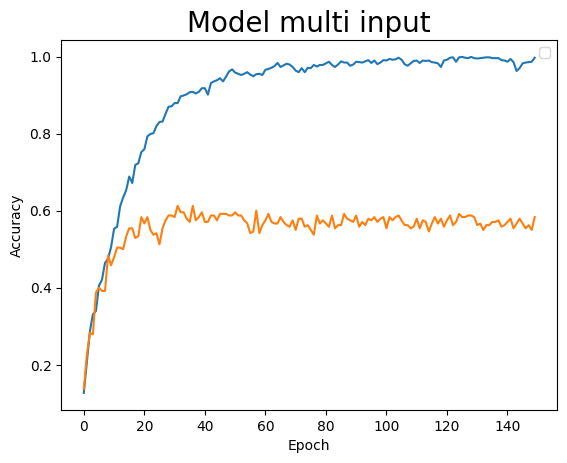

In [54]:
# Оображаем график точности обучения
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title(label='Model multi input', fontsize=20)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Evaluate the model
Загружаем лучшие веса модели и оцениваем модель

In [55]:
model_rat.load_weights(DIR + 'model_rat_3_w.h5')

In [56]:
loss, accuracy = model_rat.evaluate([x_rat_train, x_feat_train], y_rat_train)
print(f'Train, accuracy: {accuracy}, loss: {loss}')
print()

val_loss, val_accuracy = model_rat.evaluate([x_rat_val, x_feat_val], y_rat_val)
print(f'Val, accuracy: {val_accuracy}, loss: {val_loss}')

30/30 [==============================] - 5s 148ms/step - loss: 0.2660 - accuracy: 0.9583
Train, accuracy: 0.9583333134651184, loss: 0.2660471498966217

8/8 [==============================] - 1s 139ms/step - loss: 5.2737 - accuracy: 0.6125
Val, accuracy: 0.612500011920929, loss: 5.27374267578125


In [57]:
y_pred_v = model_rat.predict([x_rat_val, x_feat_val])
y_pred_am = np.argmax(y_pred_v, axis=1)
y_pred = to_categorical(y_pred_am,  num_classes=17, dtype='int')
print(y_rat_val.shape, y_pred.shape)

8/8 [==============================] - 1s 123ms/step
(240, 17) (240, 17)


In [58]:
y_pred

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [59]:
y_rat_val

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
1074,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
289,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
883,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1045,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1057,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
217,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
168,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1104,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [60]:
f1 = sklearn.metrics.f1_score(y_rat_val, y_pred, average='macro')
print(f1)

0.48614526513142226


In [61]:
model_rat.save(DIR + 'model_rat_3.keras')

# Summary
Подводим итоги - извлечение именованных сущностей и извлечение дополнительных признаков долгий процесс, но этот подход увеличивает точность на 2 - 3%